In [2]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
import json
from pathlib import Path
from utils import create_directory
from model import test
import plot as plot
import numpy as np
import matplotlib.pyplot as plt
from utils import optimize_channel

In [3]:
data_dir = create_directory(directory_name='loss0_v3')

0.027963631783859157


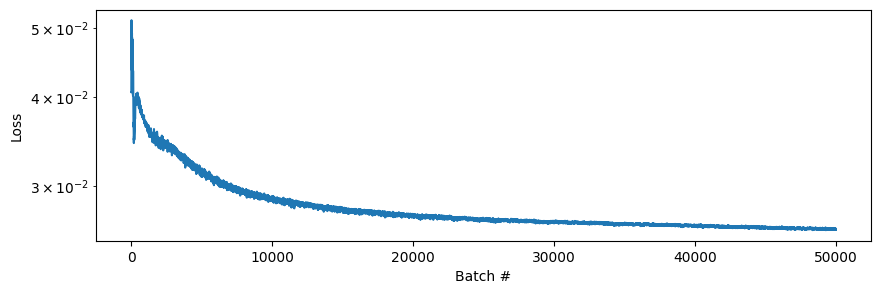

In [3]:
model_num = 0
model_name = "model{:02d}".format(model_num)

phase = 'NF2'
log_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_log.json'))[0]
log = json.load(open(log_file,'r'))
fig,ax = plot.plot_training_log(log,'position',w=1)

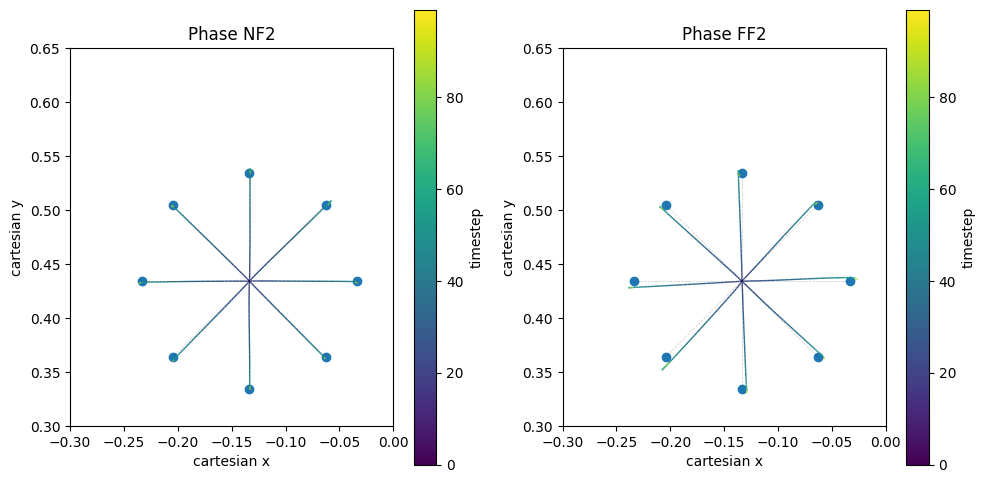

In [43]:
model_num = 4
# del 2 3 7 13
model_name = "model{:02d}".format(model_num)
data=[]
label = ['NF2','FF2']
#label = ['growing_up']
ff = [0,8,0,8]
is_channel = True
#K = 870
#B = -5
K = 150
B = -1
dT = 0.01

fig,ax = plt.subplots(1,len(label),figsize=(5*len(label),5))
for i,p in enumerate(label):
    weight_file = list(Path(data_dir).glob(f'{model_name}_phase={p}_*_weights'))[0]
    cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={p}_*_cfg.json'))[0]
    data.append(test(cfg_file,weight_file,ff_coefficient=ff[i],is_channel=is_channel,K=K,B=B,dT=dT))
    plot.plot_simulations(ax[i],xy=data[i]['xy'],target_xy=data[i]['tg'],vel=None,plot_lat=False)
    ax[i].set_title(f'Phase {p}')
    #plot.plot_simulations(ax,xy=data[i]['xy'],target_xy=data[i]['tg'],vel=None,plot_lat=False)
    #ax.set_title(f'Phase {p}')
fig.savefig(os.path.join(data_dir,'simulation.png'),dpi=300)

plt.tight_layout()
#fig.savefig(os.path.join(data_dir,'simulation.png'),dpi=300)
plt.show()


#fig, ax = plot.plot_activation(data[i]['all_hidden'],data[i]['all_muscle'],figsize=(10,15))
#fig.savefig(os.path.join(data_dir,'activation.png'),dpi=300)

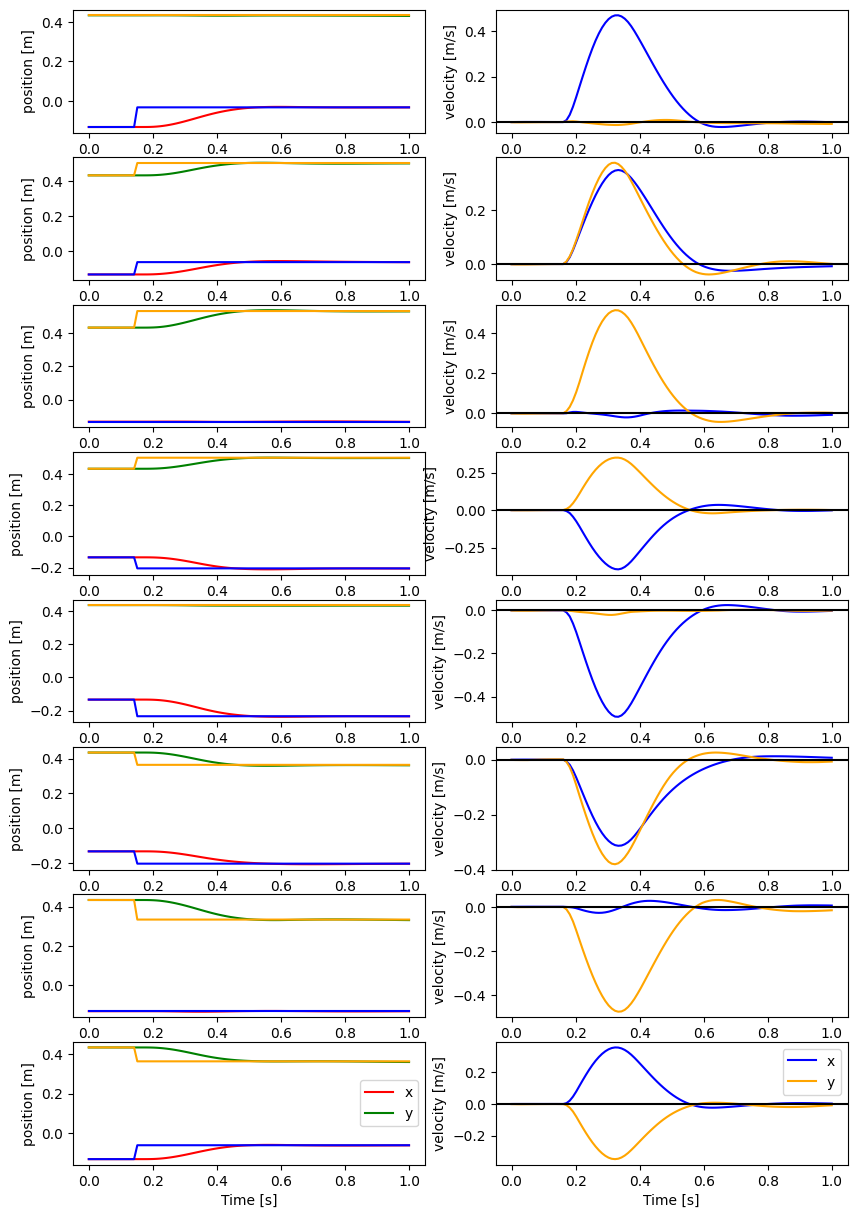

In [123]:
i = 0
fig, ax = plot.plot_kinematic(data[i]['vel'],data[i]['xy'],data[i]['tg'],figsize=(10,7.5))
fig.savefig(os.path.join(data_dir,'kinematic.png'),dpi=300)

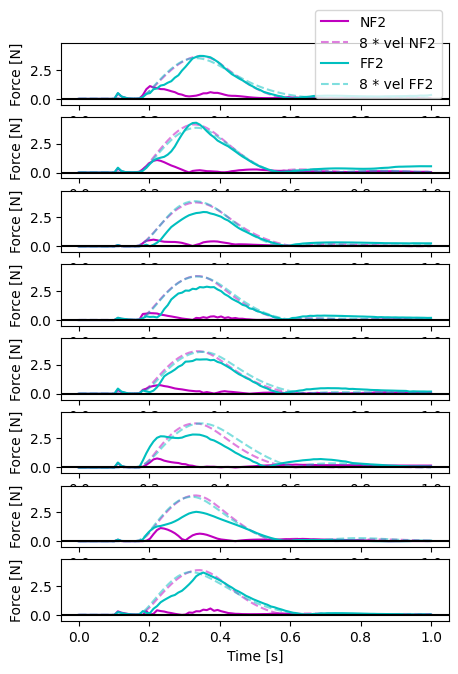

In [46]:
fig, ax = plot.plot_force(data,label,figsize=(5,7.5))
fig.savefig(os.path.join(data_dir,'lat_force.png'),dpi=300)